# Pitching and plunging for power extraction

This notebook is set up to study power extraction with an airfoil undergoing pitching and plunging oscillations in a free stream. The problem is solved in a reference frame attached to the body to allow it to run faster. The free stream is introduced as a steady motion of the body in the $-x$ direction.

In [2]:
#] add ViscousFlow

In [3]:
using ViscousFlow

In [4]:
using LinearAlgebra
using Statistics
using Plots

Let's define a macro that allows us to visualize the kinematics
of the body from the perspective of the inertial reference frame.

In [5]:
macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, init_motion_state(bc,$m)
            dxdt = zero(x0)
            x = copy(x0)
            @gif for t in t0:$dt:t0+$tmax
                motion_rhs!(dxdt,x,($m,bc),t)
                global x += dxdt*$dt
                update_body!(bc,x,$m)
                plot(bc,xlims=$xlim,ylims=$ylim)
            end every 5
        end)
end

@animate_motion (macro with 1 method)

In addition to calculating the force and moment on the body, you will need to calculate the power extracted by the body from the flow. The function below will do that. 

### Set the Reynolds number

In [6]:
my_params=Dict()
my_params["Re"] = 200

c = 1.0 # reference length (chord of wing)
U0 = 1.0 # reference velocity
my_params["freestream speed"] = U0

1.0

In [7]:
#= Create a domain big enough to hold the significant vorticity shed from the blade.
We loosen the grid Re a bit to allow it to run fast enough
The CFL condition is adjusted downward a bit so that the time marching remains stable.
=#


# Grid for pitching/plunging
xlim = (-1.0,3.5)
ylim = (-3.0,3.0)


#=
# Grid for VAWT
xlim = (-2.0,4.0)
ylim = (-3.5,2.0)
=#

my_params["grid Re"] = 4.0
my_params["CFL"] = 0.35 
g = setup_grid(xlim,ylim,my_params)
Δs = surface_point_spacing(g,my_params)

0.027999999999999997

### Pitching and plunging airfoil problem
Here, we will set the kinematics for a pitching/plunging wing for energy extraction (or propulsion). The pitching will occur about a point 1/3 of the chord length behind the leading edge (or 1/6 in front of the center). In the coordinate system we are solving in, the leading edge points to the left and is at x = -c/2 and y = 0, so we place the pitch axis at xpiv = [-c/6,0]. Lengths are all scaled by c, so c is set to 1.

The airfoil is placed in a freestream of speed $U_0$. Velocities are scaled by $U_0$, so we set this speed to 1.

The reduced frequency is `fstar = fc/U0`.

Run the next line if you want to set up this problem.

In [8]:
## These are the parameters that can be set for each problem

# Pivot point on wing
xpiv = [-c/6, 0.0]

fstar = 0.14 # fstar = fc/U0
θ0 = 76.33*π/180 # Amplitude of pitching.

H0 = 1*c # Amplitude of plunging
ϕy = -90π/180; # phase lag of the plunging to the pitching is -90 degrees (i.e. plunging *leads* pitching by 90 degrees)


#### Below this line, no need to be change ####
Ω = 2π*fstar*U0/c # Pitching/plunging angular frequency (rad/time)
Tp = 2π/Ω # Period of pitching/plunging
ϕα = 0.0 # phase of pitching
α̇0 = Ux = Uy = 0.0; # mean angle and speeds


## Create the motion, and set the center of rotation and motion into the Dict
parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # transform from inertial system to joint
α = 0  # Mean angle of the joint on the body
Xc = MotionTransform(xpiv,α)

adof = OscillatoryDOF(θ0,Ω,ϕα,α̇0) # Oscillatory angle (pitching)
xdof = ConstantVelocityDOF(Ux)    # Constant velocity in x
ydof = OscillatoryDOF(H0,Ω,ϕy,Uy) # Oscillatory y motion (plunging)
dofs = [adof,xdof,ydof]

3-element Vector{AbstractPrescribedDOFKinematics}:
 Oscillatory kinematics (amplitude = 1.3322098180472717, ang freq = 0.8796459430051422, phase = 0.0, mean velocity = 0.0)
 Constant velocity kinematics (velocity = 0.0)
 Oscillatory kinematics (amplitude = 1.0, ang freq = 0.8796459430051422, phase = -1.5707963267948966, mean velocity = 0.0)

Calculate the feathering parameter. $\chi > 1$ indicates (likely) power extraction; $\chi < 1$ is propulsion

In [9]:
χ = θ0/atan(Ω*H0/U0)

1.8465591085576052

Compute quarter period effective angle of attack

In [10]:
f = fstar * U0 / c
γ = 2*pi*f
α = abs(atan(γ*H0/U0) - θ0) * 180 / pi

34.99365736885437

### Vertical axis wind turbine
Here, we set the kinematics for a vertical axis wind turbine. A single blade of length $c$ rotates about a hub at a distance $R$, with angular velocity $\dot{\alpha}$, in a free stream of velocity $U_0$.

Velocities are scaled by $U_0$, so we set this speed to 1. Lengths are scaled by $c$, so we set this to 1. The ratio $\lambda = R/c$ sets the hub radius.

The ratio of the free stream to the rotational speed is the Rossby number, $\mathrm{Ro} = U_0/(2\dot{\alpha}c)$

Run the next line if you want to set up that problem

In [11]:
#=
# Parameters that could be changed
Ro = 1.5  # Rossby number (Ro = U0/2α̇c)
λ = 2.0   # Ratio of hub radius to blade chord length
α = 0π/180 # Angle of attack of the blade with respect to the rotation


#### Below this line, no need to be change ####
α̇ = U0/(2*Ro*c)  # Angular velocity of the turbine
Tp = 2π/α̇  # Period of rotation
R = λ*c

parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # transform from inertial system to joint
xpiv = [-0*c/6,-R] # location of pivot point relative to the center of the blade 
Xc = MotionTransform(xpiv,0)*MotionTransform([0,0],α)

adof = ConstantVelocityDOF(α̇)
xdof = ConstantVelocityDOF(0)
ydof = ConstantVelocityDOF(0)
dofs = [adof,xdof,ydof]
=#

### Create the joint

In [12]:
joint1 = Joint(FreeJoint2d,parent_body,Xp,child_body,Xc,dofs)

Joint of dimension 2 and type FreeJoint2d
   Constrained dofs = [1, 2, 3]
   Exogenous dofs = Int64[]
   Unconstrained dofs = Int64[]


#### Create the NACA 0015 airfoil

In [13]:
body = NACA4(0015,Δs,len=c)

NACA 4-digit airfoil with 73 points and length 1.0 and thickness 0.15
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [14]:
m = RigidBodyMotion(joint1,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


[ Info: Saved animation to C:\Users\bill\MAE150A\MAE250A\final project\tmp.gif


Plots.AnimatedGif("C:\\Users\\bill\\MAE150A\\MAE250A\\final project\\tmp.gif")
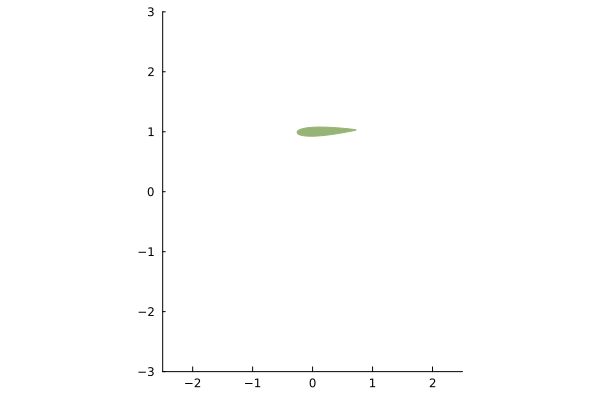

In [15]:
@animate_motion body m Tp/200 4Tp (-2.5,2.5) (-3,3)

### Set the boundary conditions
We need to provide specialized boundary conditions for this problem,
and we use the function surface_velocity_in_translating_frame!
for that. Because we are simulating a flat plate, both the positive
and negative sides of the surface must have their boundary velocities
set the same way. If this were instead a closed body, we would set either
the positive or negative side's value to zero.

In [16]:
function my_vsplus(t,x,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsplus,x,base_cache,motions,t)
  return vsplus
end

function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsminus,x,base_cache,motions,t)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => my_vsminus
  "exterior" => my_vsplus

### Set up the system structure and initial conditions
This is done the usual way

In [17]:
sys = viscousflow_system(g,body,phys_params=my_params,bc=bcdict,motions=m,reference_body=1);

In [18]:
u0 = init_sol(sys)
tspan = (0.0,4Tp)
integrator = init(u0,tspan,sys,saveat=5timestep(u0,sys)) # Saves data every 5 time steps

t: 0.0
u: (Dual nodes in a (nx = 231, ny = 302) cell grid of type Float64 data
  Number of Dual nodes: (nx = 231, ny = 302), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0])

### Solve the problem
Here, we will advance it for one period. You can run this again and again without re-initializing, which allows you to check the progress.

In [19]:
step!(integrator,2*Tp)

### Plot it
Plot the vorticity field. Note that this is plotted in the body's coordinate system, not the inertial system.

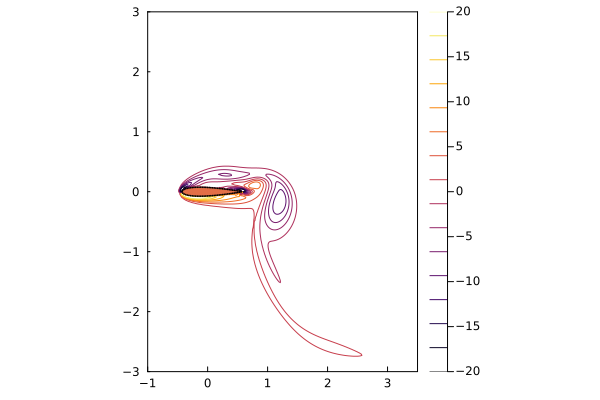

In [31]:
plot(vorticity(integrator),sys,bodyfill=true,clim=(-20,20),levels=range(-20,20,length=16),xlim=xlim,ylim=ylim, colorbar = :right)
#savefig("2_vorticity.png")

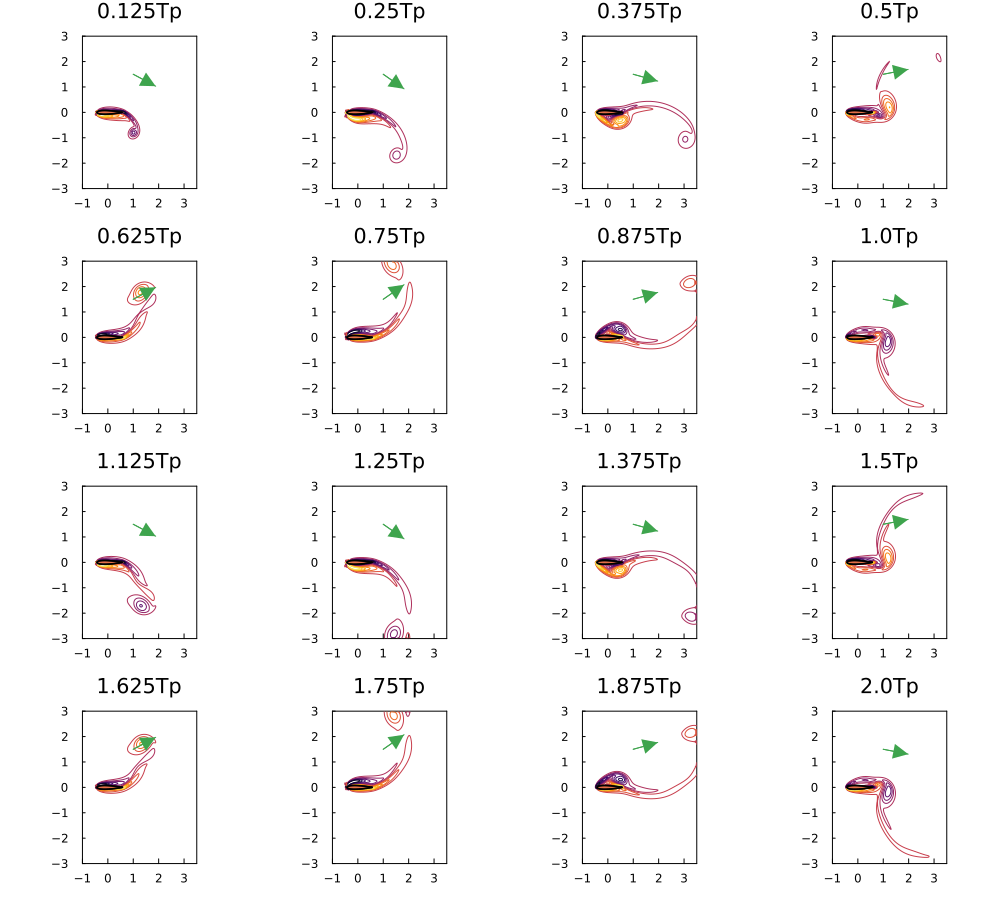

In [29]:
sol = integrator.sol
plt = plot(layout = (4,4), size = (1000, 900), legend=:false)
tsnap = 2*Tp/16:2*Tp/16:2*Tp
xarrow = [1,1.5]
len_arrow = 1.0
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,bodyfill=true,clim=(-20,20),levels=range(-20,20,length=16),xlim=xlim,ylim=ylim,title="$(round(t/Tp,digits=4))Tp")
    # Plot an arrow for the free stream
    Vinf = [ViscousFlow.evaluate_freestream(sol,sys,t)...]
    Vinf ./= norm(Vinf)
    plot!(plt[i],[xarrow[1],xarrow[1]+len_arrow*Vinf[1]],[xarrow[2],xarrow[2]+len_arrow*Vinf[2]],arrow=(:closed))
end
plt
#savefig("22_vorticities.png")

### Plot the forces and moments
This plots the forces in the coordinate system of the body. Thus, `fx` is the force along the blades's chord, and `fy` is the force perpendicular to the blade's chord.

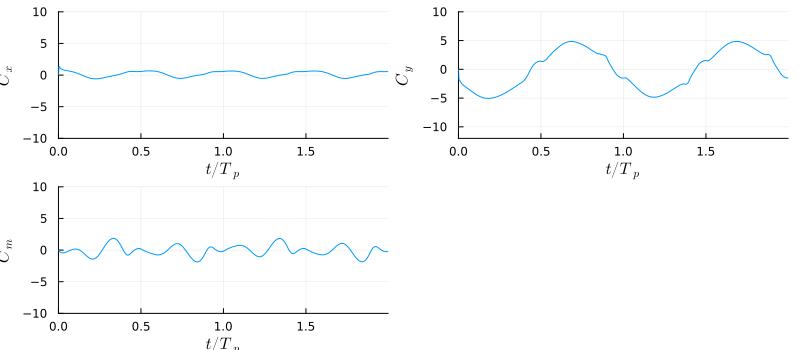

In [22]:
mom, fx, fy = force(sol,sys,1,axes=1,force_reference=1);

plot(
plot(sol.t/Tp,fx/(0.5*U0^2*c),xlim=(0,Inf),ylim=(-10,10),xlabel="\$t/T_p\$",ylabel="\$C_x\$",legend=:false),
plot(sol.t/Tp,fy/(0.5*U0^2*c),xlim=(0,Inf),ylim=(-12,10),xlabel="\$t/T_p\$",ylabel="\$C_y\$",legend=:false),
plot(sol.t/Tp,mom/(0.5*U0^2*c^2),xlim=(0,Inf),ylim=(-10,10),xlabel="\$t/T_p\$",ylabel="\$C_m\$",legend=:false),
    size=(800,350)
)

#savefig("22_forces.png")

### Plot the extracted power
This computes the power coefficient,
$$C_p = \frac{\dot{W}}{\frac{1}{2} \rho U_0^3 c}$$

If this power is positive, then it means that work is being done on the blade by the fluid, which means that energy is delivered from the fluid into the body, i.e., energy is extracted from the flow. If it is negative, then energy is delivered into the fluid.

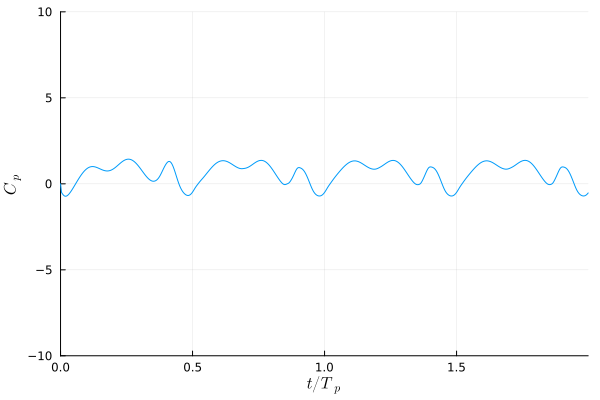

In [23]:
Cp = power(sol,sys,1)/(0.5*U0^3*c)
plot(sol.t/Tp,Cp,legend=false,xlabel="\$t/T_p\$",ylabel="\$C_p\$",xlim=(0,Inf),ylim=(-10,10))
#savefig("22_cp.png")

In [24]:
mean(Cp)

0.6087201032066624

In [25]:
d = 2 * H0 
η = mean(Cp) * c / d

0.3043600516033312

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*